<div class="admonition abstract">
<p class="admonition-title">Requirements</p>
    <ul>
        <li>python>=3.11</li>
        <li>pandas==2.3.0</li>
        <li>seaborn==0.13.2</li>
        <li>matplotlib==3.10.3</li>
        <li>numpy==2.3.1</li>
        <li>scipy==1.16.0</li>
    </ul>
</div>

<div class="admonition input">
    <p class="admonition-title">Input data</p>
    <ul>
     <li><a href=https://github.com/KTest-VN/lps_paper/tree/main/evaluation/downstream/data/raw_prs_scores> Raw PRS scores</a></li>
     </ul>
</div>

## Processing raw data

In [2]:
## Import Python packages
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
## Input variables
raw_prs_scores = '../../../evaluation/downstream/data/raw_prs_scores'

output_figs_folder = '../../../evaluation/downstream/out_figs/prs_performance'
output_table_folder = '../../../evaluation/downstream/out_tables/prs_performance/prs_cor'

In [9]:
def read_prs(path):
    """
    Read a polygenic risk score (PRS) file using pandas.
    """
    return pd.read_table(path, sep='\s+')

In [28]:

def get_cor_array(wgs, array, pop, trait, dir = raw_prs_scores):
    """
    Compute correlation between WGS PRS and array-based PRS for a given population and trait.

    Parameters:
    ----------
    wgs : pd.DataFrame
        DataFrame containing WGS PRS scores.
    array : str
        Name of the array technology (e.g., 'GSA', 'OMNI2.5').
    pop : str
        Population identifier (e.g., 'AFR', 'EUR').
    trait : str
        Trait name (e.g., 'BMI', 'DIABETES').
    dir : str
        Directory path containing the PRS files.

    Returns:
    -------
    list of float
        List of correlation values between corresponding columns in WGS and array PRS.
    """
    array_path = f"{dir}/{array}_{pop}_{trait}.all_score"
    arr = read_prs(array_path)
    cols = wgs.columns[2:]
    res = [wgs[col].corr(arr[col]) for col in cols]
    return res


In [29]:
def get_cor_pop(pop, array_list, trait_list=None, dir = raw_prs_scores):
    """
    Compute correlation values for all arrays and traits for a specific population.

    Parameters:
    ----------
    pop : str
        Population identifier.
    array_list : list of str
        List of array technologies to compare.
    trait_list : list of str, optional
        List of traits to analyze. Defaults to ['BMI', 'CAD', 'DIABETES', 'METABOLIC'] if None.
    dir : str
        Directory path containing the PRS files.

    Returns:
    -------
    pd.DataFrame
        Long-format DataFrame containing correlations, array type, trait, and population.
    """
    if trait_list is None:
        trait_list = ['BMI', 'CAD', 'DIABETES', 'METABOLIC']
    
    res = {}

    for trait in trait_list:
        wgs_path = f"{dir}/WGS_{pop}_{trait}.all_score"
        wgs = read_prs(wgs_path)
        
        all_cor = {}
        for array in array_list:
            all_cor[array] = get_cor_array(wgs, array, pop, trait)
        
        df = pd.DataFrame(all_cor)
        df = pd.melt(df, var_name='array', value_name='value')
        df['trait'] = trait

        res[trait] = df
        
    df = pd.concat(res, ignore_index=True)
    df['pop'] = pop
    return df

In [35]:
## Combine array and LPS data
array_list = ['global-screening-array-v.3X',
	'Axiom_JAPONICAX',
	'Axiom_UKB_WCSGX',
	'Axiom_PMRAX',
	'Axiom_PMDAX',
	'cytosnp-850k-v1.2X',
	'infinium-omni2.5.v1.5X', 
	'infinium-omni5-v1.2X',
	'LPS0.5X',
	'LPS0.75X',
	'LPS1.0X',
	'LPS1.25X',
	'LPS1.5X',
	'LPS2.0X']

trait_list = ['HEIGHT', 'BMI', 'DIABETES', 'METABOLIC']
pop_list = ["AFR", "AMR", "EAS", "EUR", "SAS"]

res_all = {}

for pop in pop_list:
    res_all[pop] = get_cor_pop(pop, array_list, trait_list)

data = pd.concat(res_all.values(), ignore_index=True)

In [34]:
## Polising data
data.replace({'array': {
    'Axiom_PMRAX': 'PMRA',
    'Axiom_JAPONICAX': 'JAPONICA',
    'infinium-omni2.5.v1.5X': 'OMNI2.5',
    'cytosnp-850k-v1.2X': 'CYTOSNP',
    'global-screening-array-v.3X': 'GSA',
    'infinium-omni5-v1.2X': 'OMNI5',
    'Axiom_PMDAX': 'PMDA',
    'Axiom_UKB_WCSGX': 'UKB_WCSG',
    'LPS0.5X': 'LPS_0.5',
    'LPS0.75X': 'LPS_0.75',
    'LPS1.0X': 'LPS_1.0',
    'LPS1.25X': 'LPS_1.25',
    'LPS1.5X': 'LPS_1.5',
    'LPS2.0X': 'LPS_2.0',
}}, inplace=True)
data['type'] = ['lowpass' if 'LPS' in i else 'array' for i in data['array']]
data.columns = ['array', 'value', 'bins', 'pop', 'type']

Show the first few rows of the merged dataset

In [33]:
data.head()

,array,value,bins,pop,type
0,GSA,0.949918,HEIGHT,AFR,array
1,GSA,0.948261,HEIGHT,AFR,array
2,GSA,0.949350,HEIGHT,AFR,array
3,GSA,0.949349,HEIGHT,AFR,array
4,GSA,0.946509,HEIGHT,AFR,array


## Plotting data

In [16]:
def do_filter_data(data, bins, pop):
    """
    Filter data for a specific trait bin and population.

    Parameters:
    ----------
    data : pd.DataFrame
        Long-format PRS correlation data.
    bins : str
        Trait name (used as the 'bins' column).
    pop : str
        Population identifier.

    Returns:
    -------
    pd.DataFrame
        Filtered subset of the data.
    """
    pick = (data['bins'] == bins) & (data['pop'] == pop)
    return data[pick]

In [17]:
desired_order = ['GSA', 
                'JAPONICA',
                'UKB_WCSG',
                'CYTOSNP', 
                'PMRA', 
                'PMDA',
                'OMNI2.5', 
                'OMNI5',
                'LPS_0.5',
                'LPS_0.75',
                'LPS_1.0',
                'LPS_1.25',
                'LPS_1.5',
                'LPS_2.0'] 

In [18]:
def plot_1(data, bins, pop, axe):
    """
    Plot correlation distributions for PRS arrays vs WGS for a specific population and trait.

    Parameters:
    ----------
    data : pd.DataFrame
        Long-format PRS correlation data.
    bins : str
        Trait name used for filtering.
    pop : str
        Population identifier used for filtering.
    axe : matplotlib.axes.Axes
        Axes object to plot on.

    Notes:
    ------
    - Uses Seaborn boxplot.
    - Highlights the median GSA correlation with a vertical red dashed line.
    - Orders arrays according to predefined `desired_order`.
    """
    filterd_data = do_filter_data(data, bins, pop)
    sns.boxplot(data=filterd_data, 
                y = 'array', 
                x = 'value', 
                hue='type', fill=False,
                width=0.4,
                order=desired_order,
                fliersize= 0.5,
                orient='h',
                ax=axe)
    threshold = filterd_data[filterd_data['array'] == 'GSA']['value'].median()
    axe.axvline(threshold, 0, 10, c='r', linestyle ="--", linewidth = 1)
    axe.grid(axis='both', linewidth=0.5)
    axe.legend().set_visible(False)

In [22]:
def full_plot(data):
    """
    Create a grid of boxplots showing PRS-WGS correlation distributions 
    across traits and populations.

    Parameters:
    ----------
    data : pd.DataFrame
        Long-format DataFrame with the following required columns:
        - 'array': Name of the array or sequencing method.
        - 'value': Correlation value between array and WGS PRS.
        - 'bins': Trait name (used for column grouping).
        - 'pop': Population identifier (used for row grouping).
        - 'type': Data type (e.g., 'array', 'lowpass') used for coloring.

    Behavior:
    --------
    - Generates subplots with rows = populations, columns = traits.
    - Each subplot is generated using `plot_1`, which draws a horizontal boxplot.
    - Common styling includes:
        - Fixed x-axis limits and ticks.
        - Trait names as column headers.
        - Population names as y-axis labels.
        - Hides redundant y-axis tick labels for visual clarity.
    - Saves the resulting figure to `prs_corelation.pdf` under `output_figs_folder`.

    """
    cols = data['bins'].unique()
    rows = data['pop'].unique()
    fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), figsize=(11,13))

    for i, x in enumerate(rows):
        for j, y in enumerate(cols):
            plot_1(data, y, x, axes[i,j])
            
            # Ticks
            axes[i,j].set_xlim(0.9, 1.01)
            axes[i,j].set_xticks(np.arange(0.9, 1.01, 0.02))
            axes[i,j].set_ylabel("")
            axes[i,j].set_xlabel("")
            
            if j != 0:
                pass
                
            if i == 0:
                # Title
                axes[i,j].set_title(label=y, 
                            color='white', 
                            bbox=dict(facecolor='#b3b3b3', edgecolor='white', boxstyle='round,pad=0.6'), 
                            x=0.5, pad=12,
                            fontdict={'fontsize':10})
            if j == 0:
                axes[i,j].set_ylabel(ylabel=x,
                                                color='white',
                                                labelpad = 12,
                                                rotation = 'horizontal', 
                                                bbox=dict(facecolor='#b3b3b3', 
                                                          edgecolor='white', 
                                                          boxstyle='round,pad=0.6'),
                                                fontdict={'fontsize':10})
            
    for line_num, line_axis in enumerate(axes):
        for col_num, ax in enumerate(line_axis):
            if col_num == 0:
                continue
            ax.set_ylim(line_axis[0].get_ylim()) # align axes
            plt.setp(ax.get_yticklabels(), visible=False)
                
    
    fig.tight_layout(rect=[0.02, 0.02, 1, 1])
    plt.savefig(f'{output_figs_folder}/prs_corelation.pdf', dpi=300)


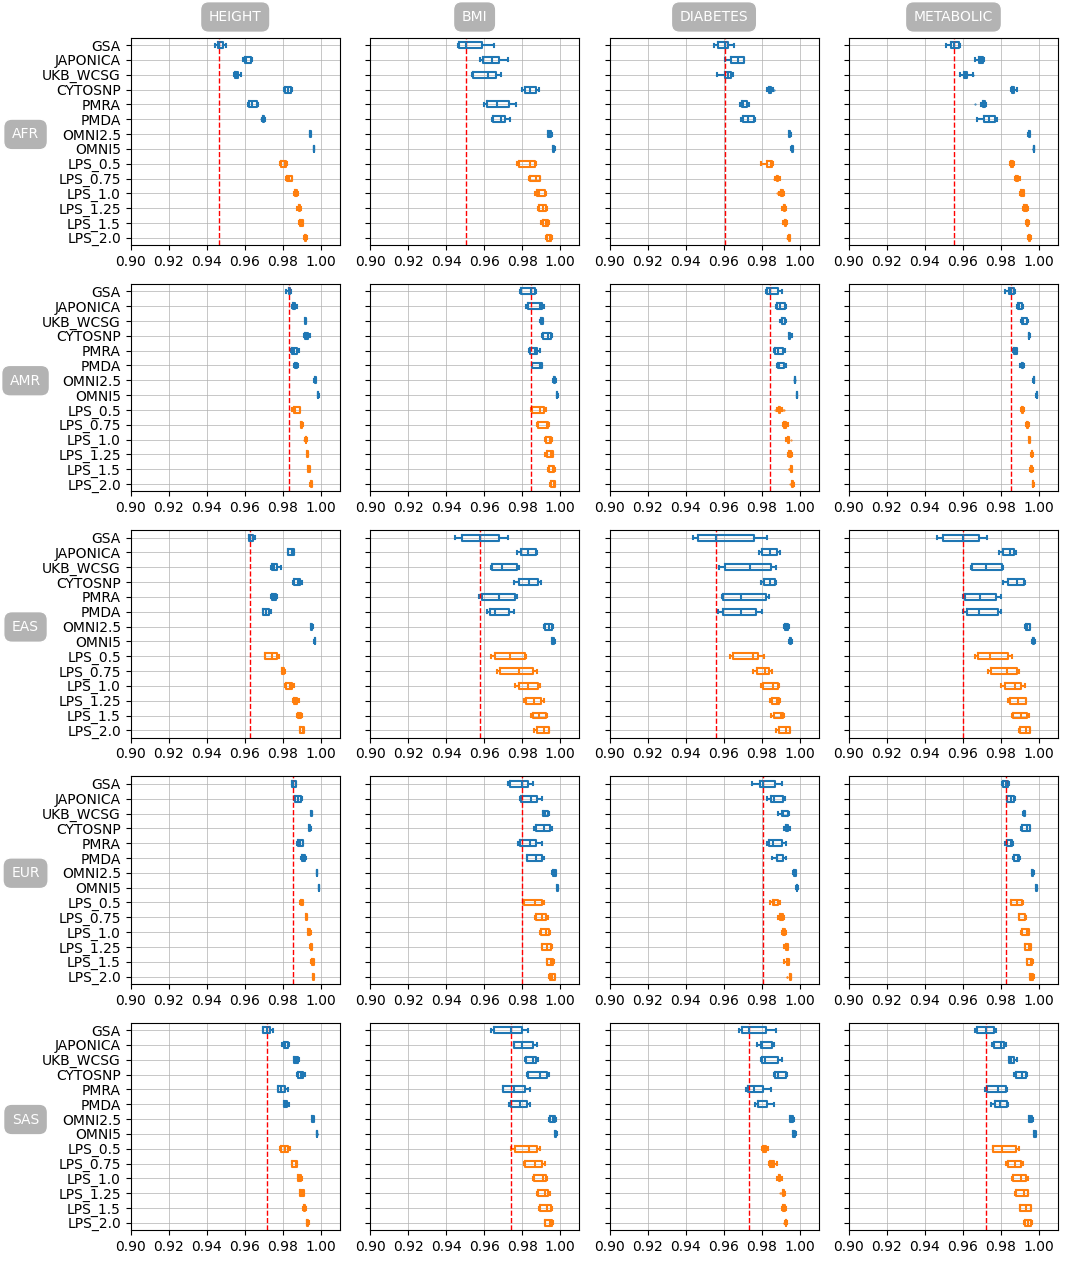

In [24]:
full_plot(data)

## Data Exporter

In [31]:
df = data
# Compute group-wise mean and standard deviation
summary = df.groupby(["type", "bins", "array", "pop"]).agg(
    mean=("value", "mean"),
    std=("value", "std")
).reset_index()

# Format summary into "mean ± std" string
summary["formatted"] = summary.apply(lambda x: f"{x['mean']:.3f} ± {x['std']:.3f}", axis=1)

# Convert to a wide-format table: each population is a column
result = summary.pivot(index=["bins", "array"], columns="pop", values="formatted").reset_index()

# Ensure arrays are ordered as defined
result["array"] = pd.Categorical(result["array"], categories=desired_order, ordered=True)
result = result.sort_values(["bins", "array"])

# Export separate CSV files for each bin
for bin_val, df_bin in result.groupby("bins"):
    df_bin = df_bin.drop(columns=["bins"])
    df_bin = df_bin.rename(columns={'array': 'Array/LPS'})
    df_bin.to_csv(f"{output_table_folder}/prs_correlation_{bin_val}.csv", index=False)

<div class="admonition output">
    <p class="admonition-title">Outputs</p>
    <ul>
        <li><a href="https://github.com/KTest-VN/lps_paper/blob/main/evaluation/downstream/out_tables/prs_performance/prs_cor">PGS correlation tables</li>
        <li><a href="https://github.com/KTest-VN/lps_paper/blob/main/evaluation/downstream/out_figs/prs_performance/Fig4_prs_corelation.pdf">PGS correlation plot</li>
    </ul>
</div>